# Multiple timeseries aproaches

Problems discription:
1. Many timeseries  from 1k to 100k
2. Hierarchy between timeseries
3. Lot of time for training and predictions

Aproaches for problems solving:
1. Use one model for yeach series (pros: customization model for each series, cons: need different model tunning for 
2. Train one model for all sereis (pros: simplicity, cons: not adequate models for different 
3. Group/clusterize series  and implement models on group, or 

Difficulties:
1. Different form of ts (sparse data, intermittent, changepoints leaps, etc)
2. Not equal importance of timeseries
3. Different frequency importance (for some - days,  for other month or quarter)


Aproaches for difficulties solving:
1. Filtering series by values (mean, zero count, etc.)
2. Classify/clusterize ts by nature
3. Apply for each ts best model

Type of forecasts model:
1. Regressions
2. Bayesian models
3. Econometrics models
4. Adaptive models

Quality scores difficulties:
1. Anadequte forecasts (too large, or negative - need find criteria for detecting sereis with problems)
2. Complex metrics for many series don't show which is more mistake


Future prediction
1. Last observation and feature for it
2. Recalculate endog features by new observations
3. Forecast exog features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss

import warnings
import numpy as np

from scipy.stats import percentileofscore
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_error

In [3]:

import sys
metric_path = '../../frameworks/time_series_signals_sound'
sys.path.append(metric_path)
eda_path = '../../frameworks/'
sys.path.append(eda_path)

In [3]:
from metrics import timeseries_metrics
from modeling import ts_models
from eda import eda_plots
from modeling import multistep
from preprocessing import feature_generation

In [4]:
def plot_prediction(train, valid, pred, title):
    plt.figure(figsize=(16,6))
    plt.plot(train, label='Train')
    plt.plot(valid, label='Valid')
    plt.plot(pred, label='Predict')
    plt.legend()
    plt.title(title)
    plt.grid()
    plt.show()

In [15]:
data = pd.read_pickle('/home/mrmopoz/jupyter_notebooks/work_projects/forecast/11.01.2021/forecast_data_2021-03-26.pckl')

In [5]:
data.head()

,id,ds,name_ru,customer,region_from,bar_code_type,count_rpo,sum_mass_kg,mean_mass
0,basildon v etoe rua->ASOS->казань->EMS->,2019-03-24,basildon v etoe rua,ASOS,казань,EMS,27,58.44,2.087143
1,basildon v etoe rua->ASOS->казань->EMS->,2019-03-25,basildon v etoe rua,ASOS,казань,EMS,4,8.83,1.766000
2,basildon v etoe rua->ASOS->казань->EMS->,2019-04-10,basildon v etoe rua,ASOS,казань,EMS,15,33.54,2.096250
3,basildon v etoe rua->ASOS->казань->EMS->,2019-04-11,basildon v etoe rua,ASOS,казань,EMS,12,28.31,2.177692
4,basildon v etoe rua->ASOS->казань->EMS->,2019-04-12,basildon v etoe rua,ASOS,казань,EMS,5,11.46,1.910000


In [7]:
pivot_data = data.pivot(index='ds', columns='id', values='sum_mass_kg').fillna(0)

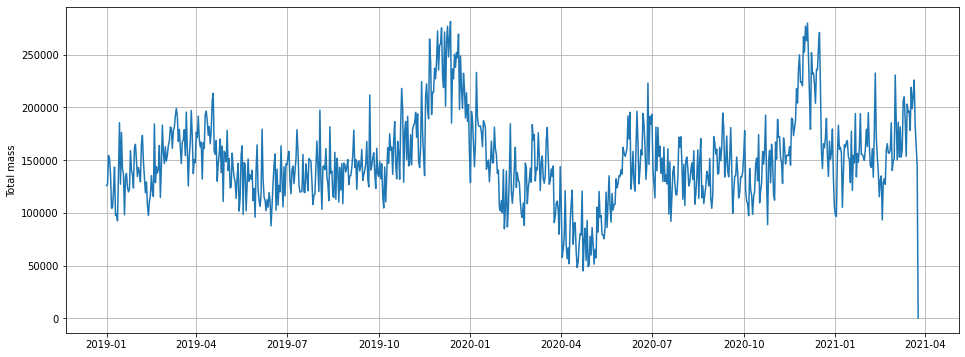

In [8]:
plt.figure(figsize=(16,6))
plt.plot(pivot_data.sum(axis=1))
plt.ylabel('Total mass')
plt.grid()
plt.show()

### Last few days not full remove it from data

In [9]:
pivot_data = pivot_data.loc[:'2021-03-21', :]

In [10]:
pivot_data.tail()

id,basildon v etoe rua->ASOS->казань->EMS->,basildon v etoe rua->ASOS->казань->RM->,basildon v etoe rua->ASOS->москва->EMS->,basildon v etoe rua->ASOS->москва->RM->,basildon v etoe rua->ASOS->москва->Посылки->,basildon v etoe rua->ASOS->санкт-петербург->EMS->,basildon v etoe rua->ASOS->санкт-петербург->RM->,basildon v etoe rua->ASOS->санкт-петербург->Посылки->,basildon v etoe rua->Alfaparcel->москва->EMS->,basildon v etoe rua->Alfaparcel->санкт-петербург->EMS->,...,япония->ИПА->владивосток->Посылка->,япония->ИПА->казань->EMS->,япония->ИПА->казань->RM->,япония->ИПА->москва->EMS->,япония->ИПА->москва->NRM->,япония->ИПА->москва->RM->,япония->ИПА->москва->Посылка->,япония->ИПА->оренбург->RM->,япония->ИПА->санкт-петербург->EMS->,япония->ИПА->санкт-петербург->RM->
ds,,,,,,,,,,,,,,,,,,,,,
2021-03-17,0.0,0.0,0.0,9271.600,1477.64,0.0,0.0,0.0,0.0,0.0,...,14.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-18,0.0,0.0,0.0,8869.111,3544.08,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-19,0.0,0.0,0.0,8249.790,1931.83,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-20,0.0,0.0,0.0,11478.853,2302.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-21,0.0,0.0,0.0,11621.566,2192.37,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


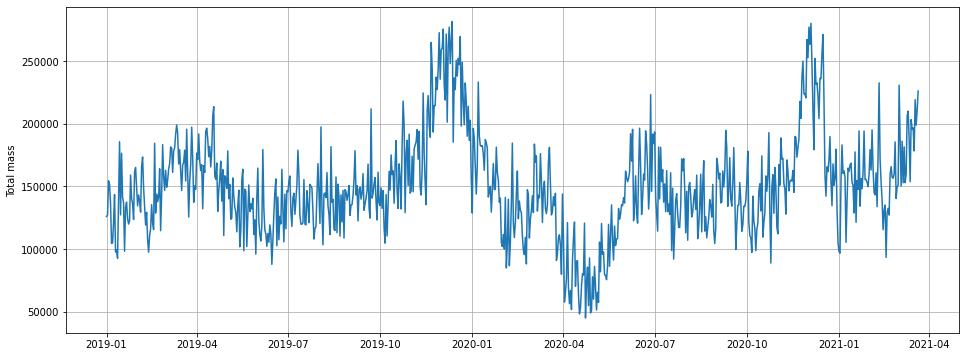

In [11]:
plt.figure(figsize=(16,6))
plt.plot(pivot_data.sum(axis=1))
plt.ylabel('Total mass')
plt.grid()
plt.show()

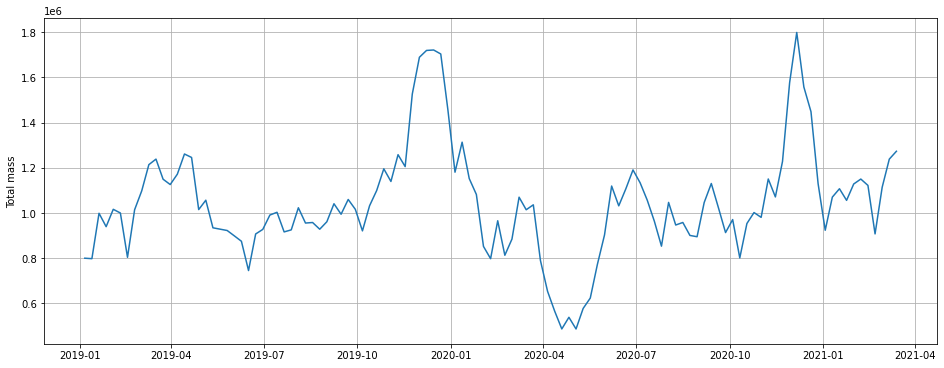

In [12]:
plt.figure(figsize=(16,6))
plt.plot(pivot_data.sum(axis=1).resample('W').sum()[:-1])
plt.grid()
plt.ylabel('Total mass')
plt.show()

## 01 Split series by diference
1. Filter by mean value
2. Check stationarity

In [13]:
pivot_data.mean().describe()

count     1339.000000
mean       111.971115
std        681.133635
min          0.000000
25%          0.036989
50%          1.085333
75%         18.446818
max      14153.731105
dtype: float64

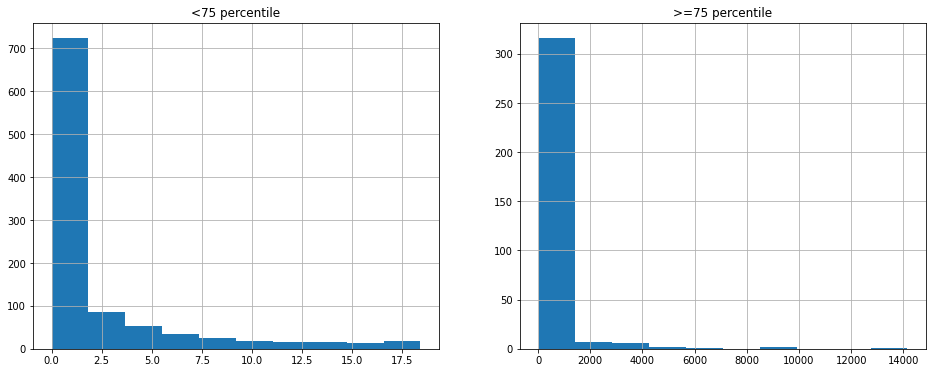

In [14]:
eda_plots.split_hist(pivot_data.mean(), percentile=75)

In [15]:
def adfuller_pval(series):
    return adfuller(series)[1]

In [16]:
ad_f = pivot_data.apply(adfuller_pval, axis=0)

/home/mrmopoz/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/mrmopoz/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/mrmopoz/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/mrmopoz/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/mrmopoz/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf 

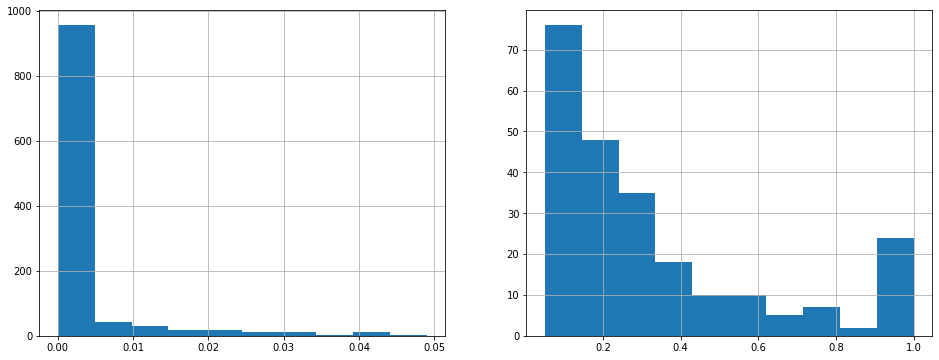

In [25]:
eda_plots.split_hist(ad_f.dropna(), percentile=percentileofscore(ad_f.dropna(), 0.05 ))

## 02 Train-test split data

In [15]:
train_data = pivot_data.loc[:'2020-12-31']
valid_data = pivot_data.loc['2021-01-01': '2021-02-28']
test_data  = pivot_data.loc['2021-03-01':]

In [49]:
pivot_data_week = pivot_data.resample('W').sum()

In [51]:
train_data_week = pivot_data_week.loc[:'2020-12-31']
valid_data_week = pivot_data_week.loc['2021-01-01': '2021-02-28']
test_data_week  = pivot_data_week.loc['2021-03-01':]

In [ ]:
train_wights = dict(train_data.sum() / train_data.sum().sum())
valid_wights = dict(valid_data.sum() / valid_data.sum().sum())

## Baseline forecast
1. Last value
2. Mean/median/mode value for period (tuning param is size of period) 
3. Mean/median/mode value for period in seasonal steps (example: mean of 10 previous weekdays values, tuning params: season period, number of periods)

In [31]:
ts = train_data[['гонконг->Alibaba->москва->RM->']]
valid_ts = valid_data[['гонконг->Alibaba->москва->RM->']]

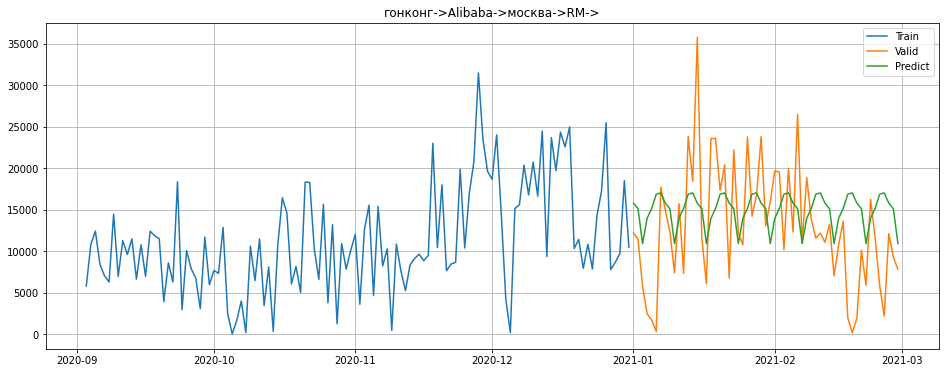

In [64]:
fcst = ts_models.baseline_forecast(ts, ftype='season mean', steps=59, n_seasons=4)
plot_prediction(ts[-120:], valid_ts, fcst, ts.columns[0])

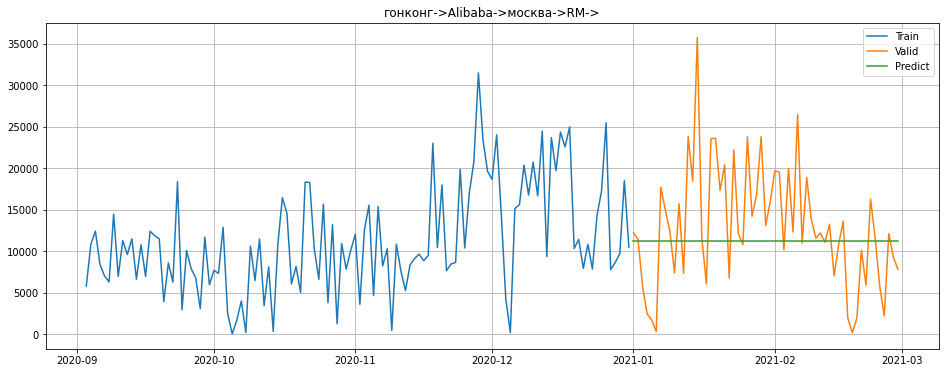

In [65]:
fcst = ts_models.baseline_forecast(ts, ftype='mean', steps=59, period=120)
plot_prediction(ts[-120:], valid_ts, fcst, ts.columns[0])

## Baseline for all sereises

In [46]:
valid_errors = {}
for col in tqdm(train_data.columns):
    valid_pred = ts_models.baseline_forecast(train_data[col], ftype='season mean', steps=59, n_seasons=4)
    valid_errors[col] = timeseries_metrics.smape(valid_data[col], valid_pred, simple=True)

/home/mrmopoz/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


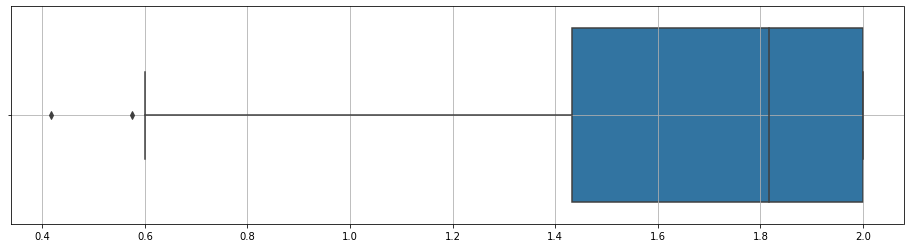

In [20]:
plt.figure(figsize=(16,4))
sns.boxplot(list(valid_errors.values()))
plt.grid()

In [47]:
w_valid_errors = {}
for col in tqdm(train_data.columns):
    w_valid_errors[col] = valid_errors[col] * valid_wights[col]

In [48]:
pd.Series(w_valid_errors.values()).sum()

0.9451317275582812

In [52]:
valid_errors = {}
for col in tqdm(train_data_week.columns):
    valid_pred = ts_models.baseline_forecast(train_data_week[col], 
                                             ftype='season mean', 
                                             steps=len(valid_data_week), 
                                             season = 4,
                                             n_seasons=4)
    valid_errors[col] = timeseries_metrics.smape(valid_data_week[col], valid_pred, simple=True)

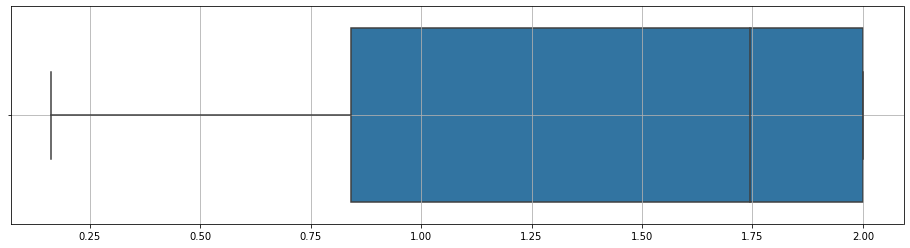

In [53]:
plt.figure(figsize=(16,4))
sns.boxplot(list(valid_errors.values()))
plt.grid()

In [55]:
w_valid_errors = {}
for col in tqdm(train_data.columns):

    
    w_valid_errors[col] = valid_errors[col] * valid_wights[col]
    
pd.Series(w_valid_errors.values()).sum()    

0.631098651081774

## 1. Adaptive forecast

In [21]:
%%time
warnings.filterwarnings('ignore')
#day data
models = {}
for col in tqdm(train_data.columns):
    exp_sm_m = ExponentialSmoothing(train_data[col],
                                  trend="additive",
                                  seasonal="additive",
                                  seasonal_periods=7, freq='D').fit(optimized=True)
    models[col] = exp_sm_m


CPU times: user 5min 57s, sys: 1.37 s, total: 5min 58s
Wall time: 5min 57s


In [28]:
train_errors = {}
valid_errors = {}
for col in tqdm(train_data.columns):
    train_pred = models[col].predict(0, len(train_data)-1)
    valid_pred = models[col].forecast(len(valid_data))
    train_errors[col] = timeseries_metrics.smape(train_data[col], train_pred, simple=True) 
    valid_errors[col] = timeseries_metrics.smape(valid_data[col], valid_pred, simple=True) 

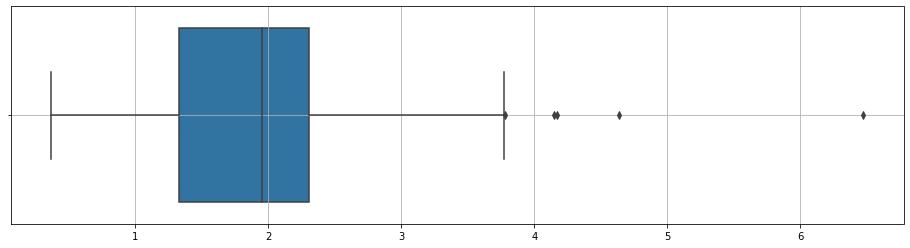

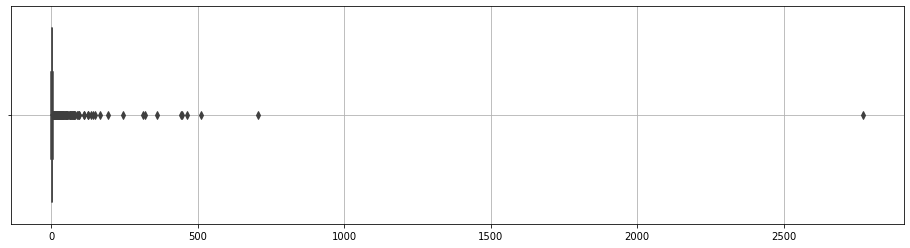

In [29]:
plt.figure(figsize=(16,4))
sns.boxplot(list(train_errors.values()))
plt.grid()
plt.show()
plt.figure(figsize=(16,4))
sns.boxplot(list(valid_errors.values()))
plt.grid()
plt.show()

In [37]:
w_train_errors = {}
w_valid_errors = {}
for col in tqdm(train_data.columns):

    w_train_errors[col] = train_errors[col] * train_wights[col]
    w_valid_errors[col] = valid_errors[col] * valid_wights[col]

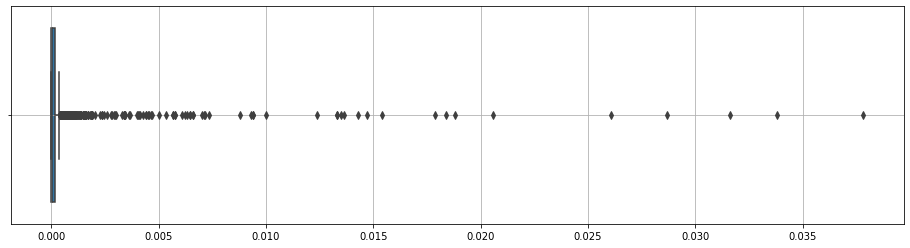

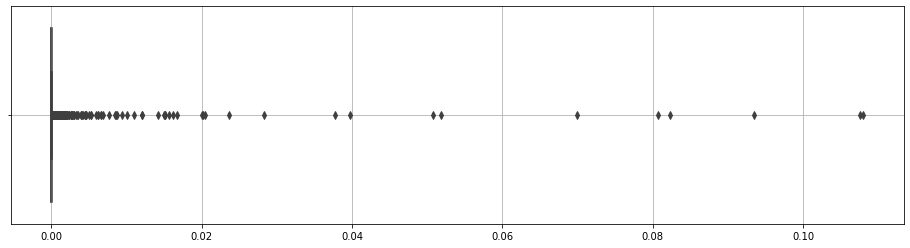

In [38]:
plt.figure(figsize=(16,4))
sns.boxplot(list(w_train_errors.values()))
plt.grid()
plt.show()
plt.figure(figsize=(16,4))
sns.boxplot(list(w_valid_errors.values()))
plt.grid()
plt.show()

In [45]:
pd.Series(w_train_errors.values()).sum()

0.7892006210497988

In [44]:
pd.Series(w_valid_errors.values()).sum()

1.300758744750731

### Data by weeks

In [56]:
%%time
warnings.filterwarnings('ignore')
#day data
models = {}
for col in tqdm(train_data_week.columns):
    exp_sm_m = ExponentialSmoothing(train_data_week[col],
                                  trend="additive",
                                  seasonal="additive",
                                  seasonal_periods=4, freq='W').fit(optimized=True)
    models[col] = exp_sm_m


CPU times: user 3min 4s, sys: 601 ms, total: 3min 5s
Wall time: 3min 4s


In [57]:
train_errors = {}
valid_errors = {}

w_train_errors = {}
w_valid_errors = {}

for col in tqdm(train_data_week.columns):
    train_pred = models[col].predict(0, len(train_data_week)-1)
    valid_pred = models[col].forecast(len(valid_data_week))
    
    train_errors[col] = timeseries_metrics.smape(train_data_week[col], train_pred, simple=True) 
    valid_errors[col] = timeseries_metrics.smape(valid_data_week[col], valid_pred, simple=True) 

    w_train_errors[col] = train_errors[col] * train_wights[col]
    w_valid_errors[col] = valid_errors[col] * valid_wights[col]    

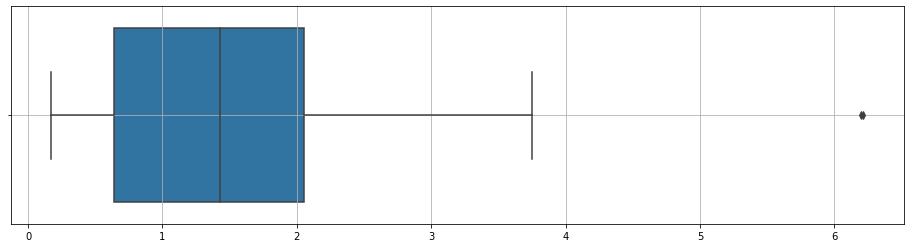

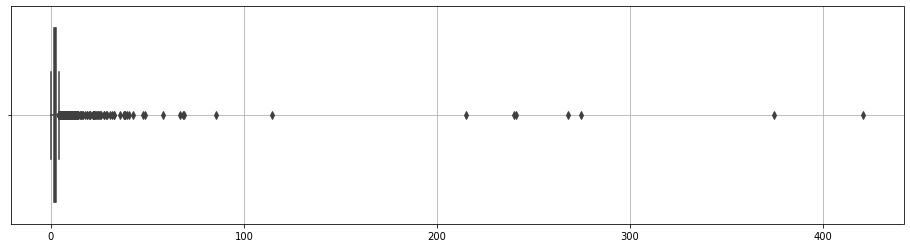

In [59]:
plt.figure(figsize=(16,4))
sns.boxplot(list(train_errors.values()))
plt.grid()
plt.show()
plt.figure(figsize=(16,4))
sns.boxplot(list(valid_errors.values()))
plt.grid()
plt.show()

In [58]:
display(pd.Series(w_train_errors.values()).sum())
display(pd.Series(w_valid_errors.values()).sum())

0.4131319699230635

0.7182365876523731

## Adaptive  for one series

/home/mrmopoz/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/home/mrmopoz/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


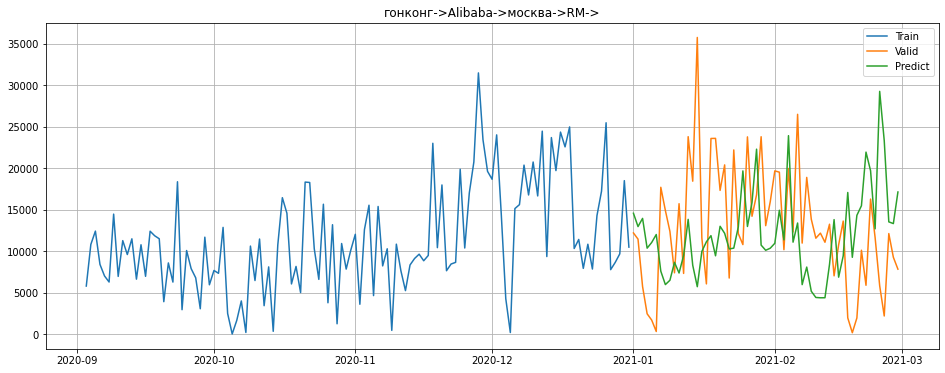

In [66]:
exp_sm_m = ExponentialSmoothing(ts,
                                  trend="additive",
                                  seasonal="additive",
                                  seasonal_periods=365, freq='D').fit(optimized=True)

pred = exp_sm_m.forecast(59)
plot_prediction(ts[-120:], valid_ts,pred, ts.columns[0])




## 2. Prophet

In [ ]:
from fbprophet import Prophet
from multiprocessing import Pool, cpu_count


def run_prophet(timeserie, periods=90):
    model = Prophet(yearly_seasonality=False,daily_seasonality=False)
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=periods, include_history=False)
    forecast = model.predict(forecast)
    return forecast

In [45]:
series = [train_data[[col]].reset_index().rename(columns={col:'y'}) for col in train_data.columns[:1]]

In [ ]:
%%time
p = Pool(cpu_count())
predictions = list(tqdm(p.imap(run_prophet, series), total=len(series)))
p.close()
p.join()

## 3. Regression aproach
1. Fit one model on each series (try direct forecast - one model on each step, or recursive forecast)
2. One model on group of serieses (all seriese, cluster, class etc.) direct or recursive forecast

### Direct multistep

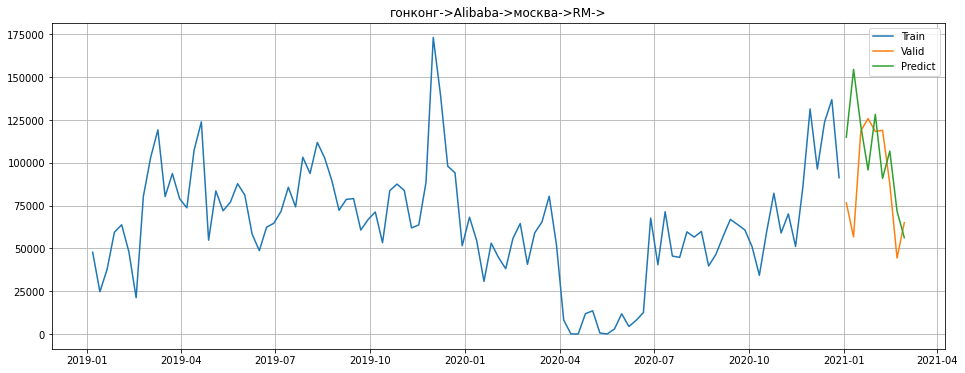

In [69]:
ts = train_data_week[['гонконг->Alibaba->москва->RM->']]
valid_ts = valid_data_week[['гонконг->Alibaba->москва->RM->']]

feature = feature_generation.generate_lags(ts, window_size=32).dropna()
f, t = feature_generation.direct_forecast_feature(feature,
                                                  'lag_1', 
                                                  steps=len(valid_ts))

dir_ms = multistep.DirectForecast(Lasso, steps=len(valid_ts))
dir_ms.fit(f,t)
pred = pd.Series(dir_ms.predict(f[1].iloc[-1].to_frame().T), index=valid_ts.index)

plot_prediction(ts[-240:], valid_ts, pred, ts.columns[0])

### One-step aprocah

In [ ]:
#1 add futuru lines
#2 generate exog features
#3 add exog and calendar features
#4 genereate exog features

In [16]:
data.head()

,id,ds,name_ru,customer,region_from,bar_code_type,count_rpo,sum_mass_kg,mean_mass
0,basildon v etoe rua->ASOS->казань->EMS->,2019-03-24,basildon v etoe rua,ASOS,казань,EMS,27,58.44,2.087143
1,basildon v etoe rua->ASOS->казань->EMS->,2019-03-25,basildon v etoe rua,ASOS,казань,EMS,4,8.83,1.766000
2,basildon v etoe rua->ASOS->казань->EMS->,2019-04-10,basildon v etoe rua,ASOS,казань,EMS,15,33.54,2.096250
3,basildon v etoe rua->ASOS->казань->EMS->,2019-04-11,basildon v etoe rua,ASOS,казань,EMS,12,28.31,2.177692
4,basildon v etoe rua->ASOS->казань->EMS->,2019-04-12,basildon v etoe rua,ASOS,казань,EMS,5,11.46,1.910000


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192891 entries, 0 to 192890
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             192891 non-null  object        
 1   ds             192891 non-null  datetime64[ns]
 2   name_ru        192891 non-null  object        
 3   customer       192891 non-null  object        
 4   region_from    192891 non-null  object        
 5   bar_code_type  192891 non-null  object        
 6   count_rpo      192891 non-null  int64         
 7   sum_mass_kg    192891 non-null  float64       
 8   mean_mass      192891 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 14.7+ MB


In [18]:
for col in ['id', 'name_ru', 'customer', 'region_from', 'bar_code_type']:
    data[col] = data[col].astype('category')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192891 entries, 0 to 192890
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             192891 non-null  category      
 1   ds             192891 non-null  datetime64[ns]
 2   name_ru        192891 non-null  category      
 3   customer       192891 non-null  category      
 4   region_from    192891 non-null  category      
 5   bar_code_type  192891 non-null  category      
 6   count_rpo      192891 non-null  int64         
 7   sum_mass_kg    192891 non-null  float64       
 8   mean_mass      192891 non-null  float64       
dtypes: category(5), datetime64[ns](1), float64(2), int64(1)
memory usage: 8.7 MB


## TODO

1. Cut off not full end of history
2. Resample data (?)
3. Add future
4. Genereate feature

In [14]:
# add future


add_grid = pd.DataFrame()
for i in range(1,29):
    temp_df = train_df[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df['d'] = 'd_'+ str(END_TRAIN+i)
    temp_df[TARGET] = np.nan
    add_grid = pd.concat([add_grid,temp_df])

grid_df = pd.concat([grid_df,add_grid])
grid_df = grid_df.reset_index(drop=True)

In [12]:
# extract calendar features
data['year'] = data['ds'].dt.year
data['month'] = data['ds'].dt.month
data['day'] = data['ds'].dt.day
data['weekday'] = data['ds'].dt.weekday
data['quarter'] = data['ds'].dt.quarter
data['weekofyear'] = data['ds'].dt.isocalendar().week

## Cluster series

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(pivot_data).T
std_data = pd.DataFrame(X, index=pivot_data.columns, columns=pivot_data.index)

In [ ]:
# find optimal cluster number
def plot_cluster_KMeans(data, max_cluster=20, random_state=10):
    range_n_clusters = range(2, max_cluster)
    clusters = []
    inertias = []
    silhouette = []
    for n_clusters in range_n_clusters:
        
        cluster = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = cluster.fit_predict(data)
        
        clusters.append(cluster)
        inertias.append(cluster.inertia_)
    
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette.append(silhouette_avg)
    
    fig, axs = plt.subplots(1,2, figsize=(16,4))
    axs[0].plot(range_n_clusters, inertias)
    axs[0].grid()
    axs[0].set_title('Inertia in depends of cluster numbers')
    axs[0].set_xlim([2,max_cluster])
    
    
    
    axs[1].plot(range_n_clusters, silhouette)
    axs[1].grid()
    axs[1].set_title('Silhouette score in depends of cluster numbers')
    axs[1].set_xlim([2,max_cluster])
    plt.show()
    return clusters


cluster = plot_cluster_KMeans(X)

In [ ]:
for c in cluster:
    print('Count of zone in cluster:')
    display(pd.Series(c.labels_).value_counts()) #normalize=True

In [ ]:
std_data['cluster_label'] = cluster[2].labels_

## 03-01 Metodology for choose models from set - Adaptive Selective model
1. Rolling with widow on sereis 
2. Fit set of models and predict next few steps
3. Measure erros
4. Select best model for series
5. Repeat 

In [19]:
ts = pivot_data[['китай->Alibaba->москва->cPacket->']]

In [ ]:
models = {1: model1, 2:model2}
train_errors = {}
test_errors = {}
train_window = 60 #28, 90, 180, 360
test_window = 14 #28, 60, 90, 180
forecast
for start in range(0, len(ts), train_window):
    #TODO end of history checking
    train_data = ts[start:start+train_window]
    test_data = ts[start+train_window:start+train_window+test_window]
    for key in models.keys():
        models[key].fit(train_data)
        train_errors[key] = metrics(train_data, models[key].predict())
        test_errors[key] = metrics(test_data, models[key].predict(test_window))
    # select models 
    #TODO  choics data structure
    forecst[test_data.index] = models[min(errors)].predict()

## 03-02 Metodology for choose models from set - Adaptive Composite model
1. Rolling with widow on sereis 
2. Fit set of models and predict next few steps
3. Measure erros
4. Weight models predictions by error
5. Repeat 